In [144]:
### Importing the necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

In [145]:
### Getting the real data
real_data = pd.read_csv("/Users/ardaatik/Downloads/project/data/healthcare-dataset-stroke-data.csv")
real_data.head() # 5110 row x 12 column

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [146]:
# Checking the missing values
missing_values_count = real_data.isnull().sum()
missing_values_count # only bmi 201 values are missing

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [147]:
# Calculating the missing percent
total_cells = np.product(real_data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.32778864970645794


In [148]:
# Filling the missing values
real_data.fillna(method='bfill', axis=0).fillna(0)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,32.5,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,40.0,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [149]:
# get the index of all positive pledges (Box-Cox only takes positive values)
index_of_positive_pledges = real_data.avg_glucose_level > 0

# get only positive pledges (using their indexes)
positive_pledges = real_data.avg_glucose_level.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = pd.Series(stats.boxcox(positive_pledges)[0], 
                               name='avg_glucose_level', index=positive_pledges.index)

print('Original data\nPreview:\n', positive_pledges.head())
print('Minimum value:', float(positive_pledges.min()),
      '\nMaximum value:', float(positive_pledges.max()))
print('_'*30)

print('\nNormalized data\nPreview:\n', normalized_pledges.head())
print('Minimum value:', float(normalized_pledges.min()),
      '\nMaximum value:', float(normalized_pledges.max()))

Original data
Preview:
 0    228.69
1    202.21
2    105.92
3    171.23
4    174.12
Name: avg_glucose_level, dtype: float64
Minimum value: 55.12 
Maximum value: 271.74
______________________________

Normalized data
Preview:
 0    0.943185
1    0.942763
2    0.939370
3    0.942098
4    0.942171
Name: avg_glucose_level, dtype: float64
Minimum value: 0.9325552140982971 
Maximum value: 0.9436915210348612


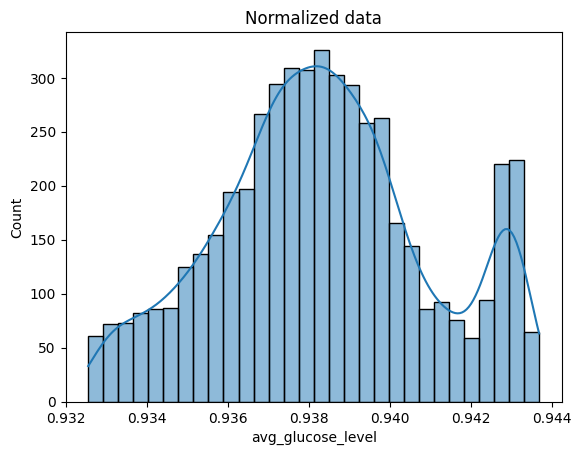

In [150]:
# Plotting histogram
ax = sns.histplot(normalized_pledges, kde=True)
ax.set_title("Normalized data")
plt.show()

In [151]:
# Extracting the unique values of gender column
gender = real_data["gender"].unique()
gender

array(['Male', 'Female', 'Other'], dtype=object)

In [152]:
# Extracting the unique values of ever_married column
ever_married = real_data["ever_married"].unique()
ever_married

array(['Yes', 'No'], dtype=object)

In [153]:
# Extracting the unique values of work_type column
work_type = real_data["work_type"].unique()
work_type

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [154]:
# Extracting the unique values of Residence_type column
Residence_type = real_data["Residence_type"].unique()
Residence_type

array(['Urban', 'Rural'], dtype=object)

In [155]:
# # Extracting the unique values of smoking_status column
smoking_status = real_data["smoking_status"].unique()
smoking_status
# So we checked and there is no typos in these columns.

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

<Axes: xlabel='heart_disease', ylabel='age'>

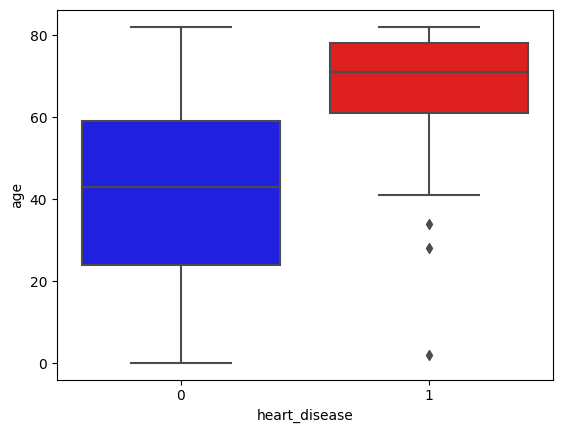

In [156]:
# Creating a boxplot to see the link between heart disease and age
sns.boxplot(x = real_data['heart_disease'], y = real_data['age'], palette= ["blue", "red"])

<Axes: xlabel='heart_disease', ylabel='smoking_status'>

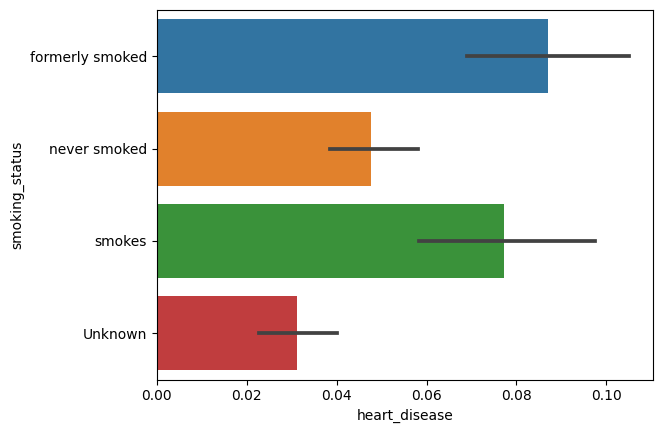

In [157]:
# Creating a barplot to see the link between heart disease and smoking status
sns.barplot(x = real_data['heart_disease'], y = real_data['smoking_status'])

<Axes: xlabel='smoking_status', ylabel='stroke'>

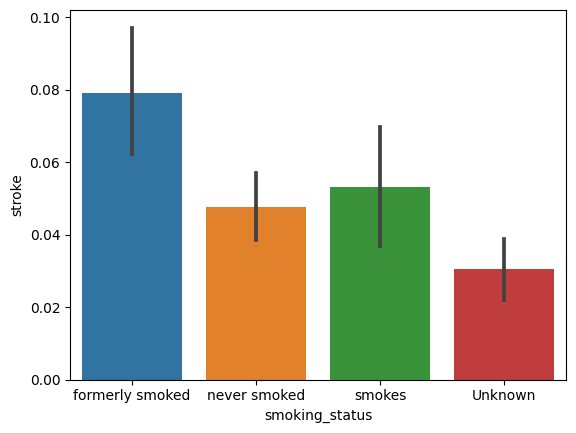

In [158]:
# Creating a barplot to see the link between smoking status and stroke
sns.barplot(x = real_data['smoking_status'], y = real_data['stroke'])

<Axes: xlabel='Residence_type', ylabel='stroke'>

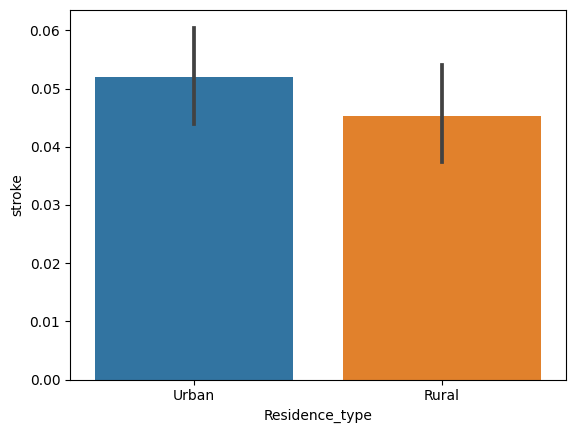

In [159]:
# Creating a barplot to see the link between residence type and stroke
sns.barplot(x = real_data['Residence_type'], y = real_data['stroke'])

<Axes: xlabel='heart_disease', ylabel='bmi'>

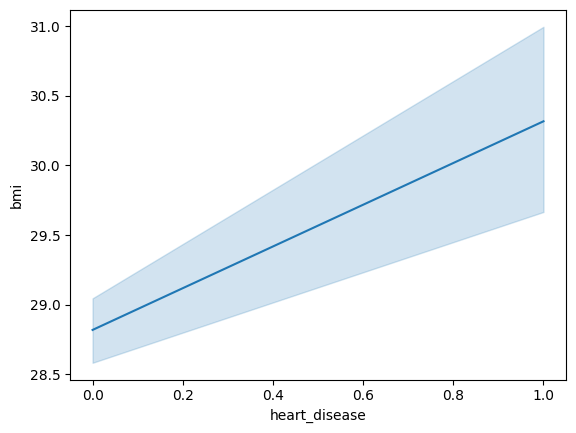

In [160]:
# Creating a lineplot to see the link between heart disease and bmi
sns.lineplot(x = real_data['heart_disease'], y = real_data['bmi'])
# The higher the bmi, the higher the likelihood of developing heart disease.

<Axes: xlabel='heart_disease', ylabel='avg_glucose_level'>

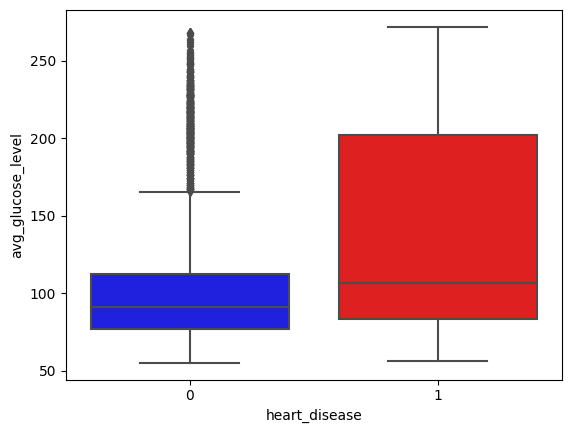

In [161]:
# Creating a boxplot to see the link between heart disease and average glucose level
sns.boxplot(x = real_data['heart_disease'], y = real_data['avg_glucose_level'], palette= ["blue", "red"])

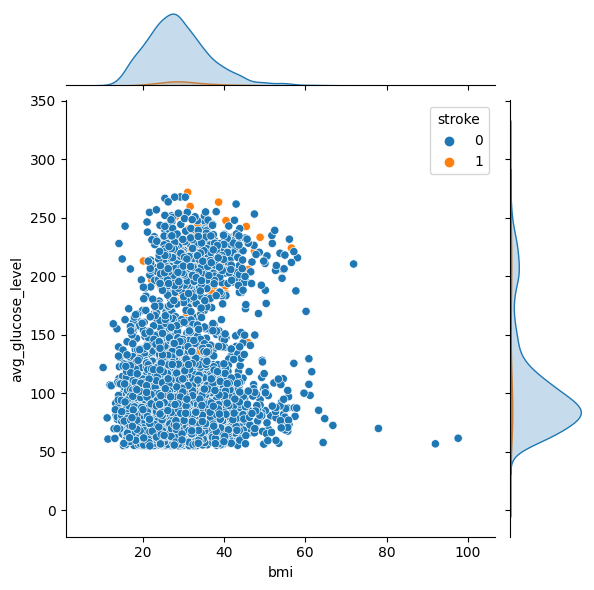

In [162]:
# Creating a scatterplot with a jointdistribution plot to see the effect of the average glucose level and bmi on the stroke
sns.jointplot(x = real_data['bmi'], y = real_data['avg_glucose_level'],kind = "scatter", hue = real_data['stroke'])

<Axes: xlabel='heart_disease', ylabel='stroke'>

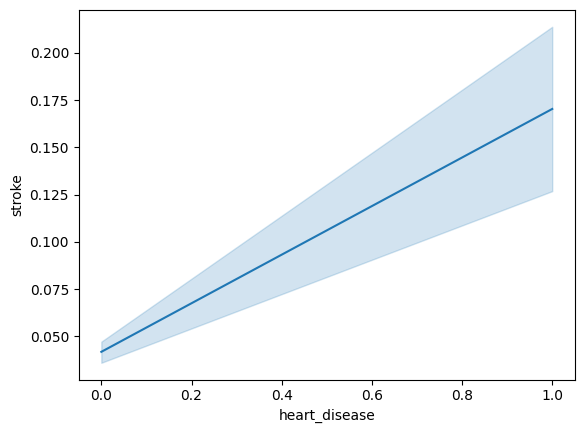

In [211]:
# Creating a lineplot to see the link between heart disease and stroke
sns.lineplot(x = real_data['heart_disease'], y = real_data['stroke'])

<Axes: xlabel='hypertension', ylabel='age'>

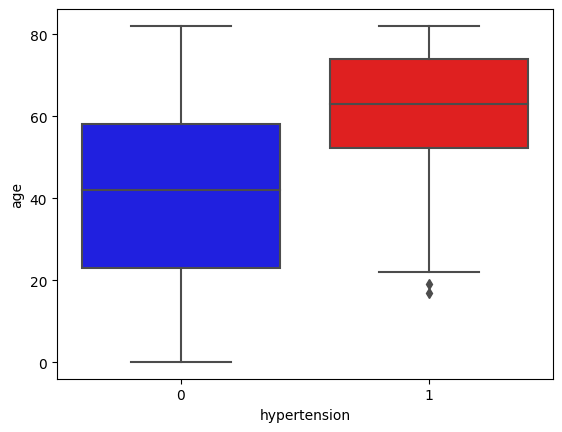

In [164]:
# Creating a boxplot to see the link between hypertension and age
sns.boxplot(x= real_data['hypertension'], y=real_data['age'], palette= ["blue", "red"])

<Axes: xlabel='hypertension', ylabel='heart_disease'>

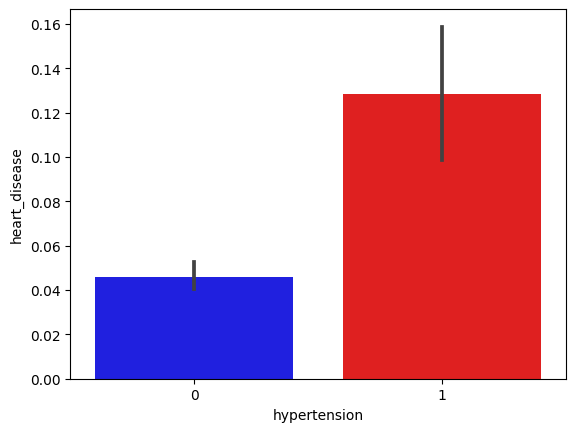

In [165]:
# Creating a barplot to see the link between hypertension and heart disease
sns.barplot(x= real_data['hypertension'], y=real_data['heart_disease'], palette= ["blue", "red"]) 

<Axes: xlabel='gender', ylabel='stroke'>

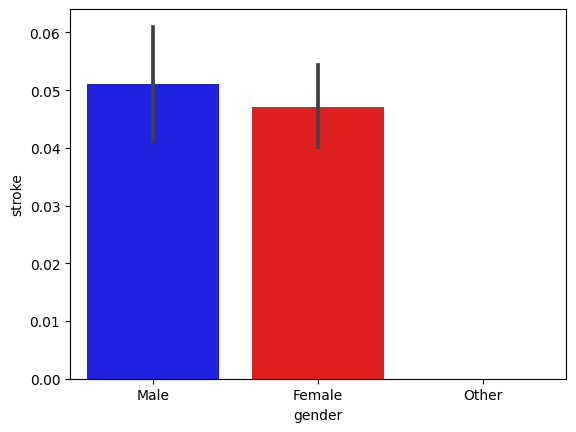

In [166]:
# Creating a barplot to see the link between gender and stroke
sns.barplot(x = real_data['gender'], y = real_data['stroke'], palette= ["blue", "red"])

<Axes: xlabel='age', ylabel='stroke'>

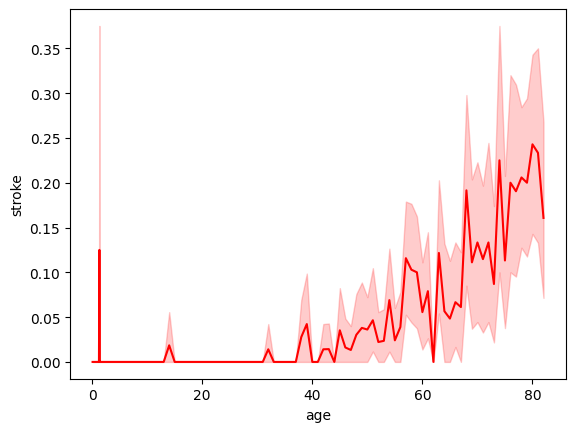

In [167]:
# Creating a lineplot to see the link between age and stroke
sns.lineplot(x = real_data['age'], y = real_data['stroke'], color = "red")

<Axes: xlabel='hypertension', ylabel='stroke'>

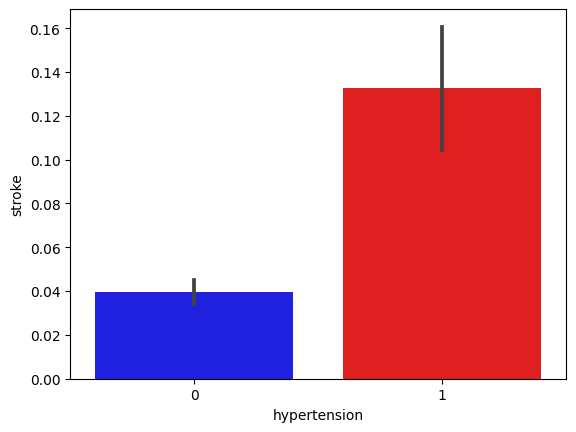

In [168]:
# Creating a barplot to see the link between hypertension and stroke
sns.barplot(x = real_data['hypertension'], y = real_data['stroke'], palette= ["blue", "red"])

<Axes: xlabel='heart_disease', ylabel='stroke'>

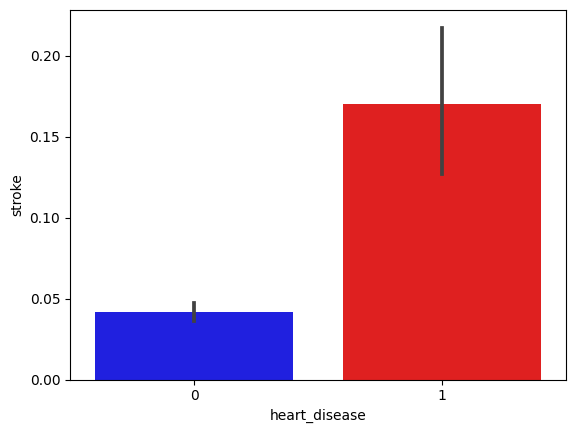

In [169]:
# Creating a barplot to see the link between heart disease and stroke
sns.barplot(x = real_data['heart_disease'], y = real_data['stroke'], palette= ["blue", "red"])

<Axes: xlabel='ever_married', ylabel='stroke'>

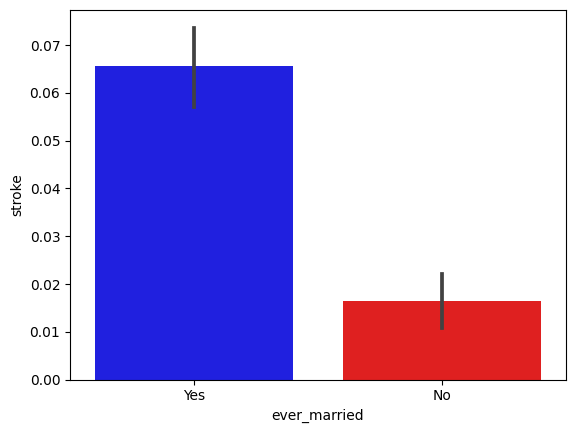

In [170]:
# Creating a barplot to see the link between marriage and stroke
sns.barplot(x = real_data['ever_married'], y = real_data['stroke'], palette= ["blue", "red"])

<Axes: xlabel='work_type', ylabel='stroke'>

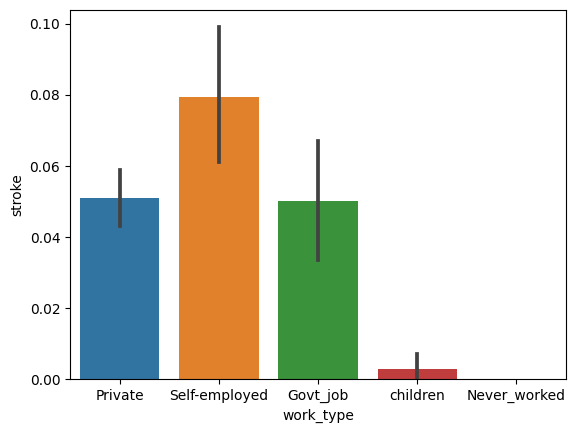

In [171]:
# Creating a barplot to see the link work type disease and stroke
sns.barplot(x = real_data['work_type'], y = real_data['stroke'])

<Axes: xlabel='Residence_type', ylabel='stroke'>

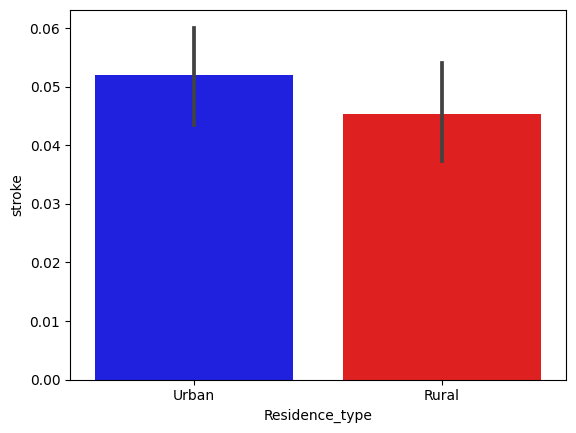

In [172]:
# Creating a barplot to see the link between residence type and stroke
sns.barplot(x = real_data['Residence_type'], y = real_data['stroke'], palette= ["blue", "red"])

<Axes: xlabel='stroke', ylabel='bmi'>

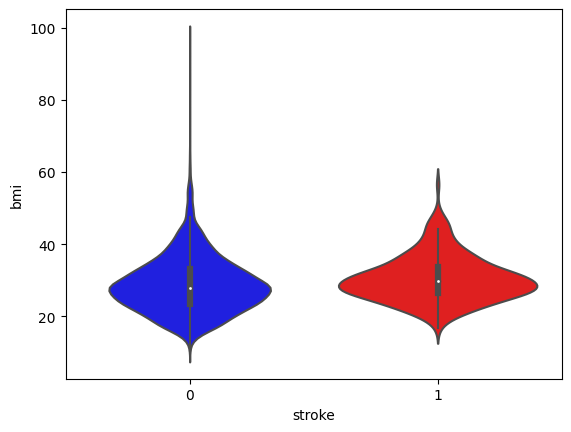

In [173]:
# Creating a violinplot to see the link between stroke and bmi
sns.violinplot(x = real_data['stroke'], y = real_data['bmi'], palette= ["blue", "red"])

In [174]:
# Reading the train and test files into dataframes
train_data = pd.read_csv("/Users/ardaatik/Downloads/project/data/train.csv")
test_data = pd.read_csv("/Users/ardaatik/Downloads/project/data/test.csv")

In [175]:
# Categorizing age values into different age groups
train_data['age_bin'] = pd.cut(train_data['age'], bins=[0, 18, 40, 60], labels=['young', 'middle-aged', 'elderly'])
test_data['age_bin'] = pd.cut(test_data['age'], bins=[0, 18, 40, 60], labels=['young', 'middle-aged', 'elderly'])


In [176]:
# Categorizing bmi values into different bmi groups
train_data['bmi_category'] = pd.cut(train_data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal weight', 'overweight', 'obese'])
test_data['bmi_category'] = pd.cut(test_data['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal weight', 'overweight', 'obese'])

In [177]:
train_data['age_hypertension_interaction'] = train_data['age'] * train_data['hypertension']
test_data['age_hypertension_interaction'] = test_data['age'] * test_data['hypertension']

In [178]:
y = real_data["stroke"]

In [179]:
stroke_features = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]
categorical_features = ["smoking_status", "ever_married"]

In [180]:
X = real_data[stroke_features]

In [181]:
X.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237
std,22.612647,0.296607,0.226063,45.283560,7.854067
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,25.000000,0.000000,0.000000,77.245000,23.500000
50%,45.000000,0.000000,0.000000,91.885000,28.100000
75%,61.000000,0.000000,0.000000,114.090000,33.100000
max,82.000000,1.000000,1.000000,271.740000,97.600000


In [182]:
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0,1,228.69,36.6
1,61.0,0,0,202.21,NaN
2,80.0,0,1,105.92,32.5
3,49.0,0,0,171.23,34.4
4,79.0,1,0,174.12,24.0


In [183]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [184]:
stroke_features_with_interaction = stroke_features + ['age_hypertension_interaction']
train_X = pd.get_dummies(train_data[stroke_features_with_interaction + categorical_features])
test_X = pd.get_dummies(test_data[stroke_features_with_interaction + categorical_features])

In [185]:
train_y = train_data["stroke"]
train_X, test_X = train_X.align(test_X, join='outer', axis=1, fill_value=0)
train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [186]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, random_state=0)

In [187]:
train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [188]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

RandomForestClassifier(random_state=42)

In [189]:
train_predictions = model.predict_proba(train_X)[:, 1]
val_predictions = model.predict_proba(val_X)[:, 1]
"""test_predictions = model.predict(test_X)"""

'test_predictions = model.predict(test_X)'

In [190]:
train_accuracy = accuracy_score(train_y, train_predictions.round())
train_report = classification_report(train_y, train_predictions.round())

In [191]:
val_accuracy = accuracy_score(val_y, val_predictions.round())
val_report = classification_report(val_y, val_predictions.round())

In [192]:
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", train_report)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:\n", val_report)

Training Accuracy: 0.9999128768078063
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10997
           1       1.00      1.00      1.00       481

    accuracy                           1.00     11478
   macro avg       1.00      1.00      1.00     11478
weighted avg       1.00      1.00      1.00     11478

Validation Accuracy: 0.9558285415577626
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      3675
           1       0.28      0.07      0.12       151

    accuracy                           0.96      3826
   macro avg       0.62      0.53      0.55      3826
weighted avg       0.94      0.96      0.94      3826



In [193]:
minmax = MinMaxScaler()
real_data[['age','avg_glucose_level','bmi']] = minmax.fit_transform(real_data[['age','avg_glucose_level','bmi']])
real_data = pd.get_dummies(real_data)
real_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0.816895,0,1,0.801265,0.301260,1,False,True,False,...,False,True,False,False,False,True,False,True,False,False
1,51676,0.743652,0,0,0.679023,NaN,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,31112,0.975586,0,1,0.234512,0.254296,1,False,True,False,...,False,True,False,False,True,False,False,False,True,False
3,60182,0.597168,0,0,0.536008,0.276060,1,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,1665,0.963379,1,0,0.549349,0.156930,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [194]:
minmax = MinMaxScaler()
train_data[['age','avg_glucose_level','bmi']] = minmax.fit_transform(train_data[['age','avg_glucose_level','bmi']])
train_data = pd.get_dummies(train_data)
train_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_hypertension_interaction,gender_Female,gender_Male,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age_bin_young,age_bin_middle-aged,age_bin_elderly,bmi_category_underweight,bmi_category_normal weight,bmi_category_overweight,bmi_category_obese
0,0,0.340820,0,0,0.114465,0.297994,0,0.0,False,True,...,False,True,False,False,True,False,False,False,False,True
1,1,0.401855,0,0,0.109332,0.194842,0,0.0,False,True,...,True,False,False,False,True,False,False,True,False,False
2,2,0.511719,0,0,0.224974,0.429799,0,0.0,True,False,...,False,False,False,False,False,True,False,False,False,True
3,3,0.682617,0,0,0.045437,0.265043,0,0.0,False,True,...,False,True,False,False,False,True,False,False,True,False
4,4,0.291992,0,0,0.085413,0.265043,0,0.0,True,False,...,False,True,False,False,True,False,False,False,True,False


In [195]:
missing_values_count_train = train_data.isnull().sum()
missing_values_count_train

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
age_hypertension_interaction      0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
age_bin_young                     0
age_bin_middle-aged               0
age_bin_elderly                   0
bmi_category_underweight    

FILTERING THE OUTLIERS OF THE TRAINING DATA

In [196]:
filtered_entries = np.array([True] * len(train_data))
for col in ['avg_glucose_level','bmi']:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((train_data[col] >= low_limit) & (train_data[col] <= high_limit)) & filtered_entries
    
train_data = train_data[filtered_entries]

In [197]:
train_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_hypertension_interaction,gender_Female,gender_Male,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age_bin_young,age_bin_middle-aged,age_bin_elderly,bmi_category_underweight,bmi_category_normal weight,bmi_category_overweight,bmi_category_obese
0,0,0.340820,0,0,0.114465,0.297994,0,0.0,False,True,...,False,True,False,False,True,False,False,False,False,True
1,1,0.401855,0,0,0.109332,0.194842,0,0.0,False,True,...,True,False,False,False,True,False,False,True,False,False
2,2,0.511719,0,0,0.224974,0.429799,0,0.0,True,False,...,False,False,False,False,False,True,False,False,False,True
3,3,0.682617,0,0,0.045437,0.265043,0,0.0,False,True,...,False,True,False,False,False,True,False,False,True,False
4,4,0.291992,0,0,0.085413,0.265043,0,0.0,True,False,...,False,True,False,False,True,False,False,False,True,False


In [198]:
train_data.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'age_hypertension_interaction', 'gender_Female',
       'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'age_bin_young', 'age_bin_middle-aged',
       'age_bin_elderly', 'bmi_category_underweight',
       'bmi_category_normal weight', 'bmi_category_overweight',
       'bmi_category_obese'],
      dtype='object')

In [199]:
df_test = pd.read_csv("/Users/ardaatik/Downloads/project/data/test.csv")
df_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [200]:
minmax = MinMaxScaler()
df_test[['age','avg_glucose_level','bmi']] = minmax.fit_transform(df_test[['age','avg_glucose_level','bmi']])
test_data = pd.get_dummies(df_test)
test_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,15304,0.694824,0,0,0.129047,0.254355,True,False,False,False,...,False,True,False,False,True,False,True,False,False,False
1,15305,0.853516,1,0,0.079725,0.197445,False,True,False,False,...,False,True,False,False,False,True,True,False,False,False
2,15306,0.060059,0,0,0.228727,0.092915,True,False,False,True,...,False,False,False,True,False,True,True,False,False,False
3,15307,0.682617,0,0,0.066453,0.347271,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,15308,0.389648,0,0,0.263695,0.216028,False,True,False,False,...,False,True,False,False,True,False,False,False,False,True


In [201]:
test_data.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [202]:
missing_values_count_test = test_data.isnull().sum()
missing_values_count_test

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [203]:
real_data.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [204]:
y = real_data.stroke

In [205]:
stroke_features =  ['age','avg_glucose_level',
       'bmi']

categorical_features = ['heart_disease', 'hypertension','gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes' ]

"""test_stroke_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']"""

"test_stroke_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level',\n       'bmi', 'gender_Female', 'gender_Male', 'gender_Other',\n       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',\n       'work_type_Never_worked', 'work_type_Private',\n       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',\n       'Residence_type_Urban', 'smoking_status_Unknown',\n       'smoking_status_formerly smoked', 'smoking_status_never smoked',\n       'smoking_status_smokes']"

In [206]:
X = real_data[stroke_features]
X.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,0.526692,0.235563,0.212981
std,0.276033,0.209046,0.089966
min,0.000000,0.000000,0.000000
25%,0.304199,0.102137,0.151203
50%,0.548340,0.169721,0.203895
75%,0.743652,0.272228,0.261168
max,1.000000,1.000000,1.000000


In [207]:
train_X = pd.get_dummies(train_data[stroke_features + categorical_features])
test_X = pd.get_dummies(test_data[stroke_features + categorical_features])
train_y = train_data["stroke"]
train_X, test_X = train_X.align(test_X, join='outer', axis=1, fill_value=0)
train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [208]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, random_state=0)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
val_predictions = model.predict(val_X)
test_predictions = model.predict(test_X)
train_accuracy = accuracy_score(train_y, train_predictions)
train_report = classification_report(train_y, train_predictions)
val_accuracy = accuracy_score(val_y, val_predictions)
val_report = classification_report(val_y, val_predictions)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:\n", train_report)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:\n", val_report)

Training Accuracy: 1.0
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10515
           1       1.00      1.00      1.00       391

    accuracy                           1.00     10906
   macro avg       1.00      1.00      1.00     10906
weighted avg       1.00      1.00      1.00     10906

Validation Accuracy: 0.9647964796479648
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3512
           1       0.38      0.05      0.09       124

    accuracy                           0.96      3636
   macro avg       0.67      0.52      0.53      3636
weighted avg       0.95      0.96      0.95      3636



In [209]:
test_predictions = model.predict_proba(test_X)[:, 1]  # Probabilities of positive class (stroke)
test_data["stroke_prediction"] = test_predictions
selected_columns = ['id', 'stroke_prediction']
submission_data = test_data[selected_columns]
submission_data.to_csv("submission.csv", index=False)

In [210]:
df = pd.read_csv("/Users/ardaatik/Downloads/project/submission.csv")
df['stroke_prediction'].value_counts()

stroke_prediction
0.00    5391
0.01    1256
0.02     619
0.03     410
0.04     292
        ... 
0.69       1
0.61       1
0.66       1
0.77       1
0.73       1
Name: count, Length: 67, dtype: int64